In [1]:
import numpy as np 
import matplotlib.pyplot as plt 

## How to implement our little model here? 

#### Let's remember what we got: 

- First we have a normal Milne-Eddington parameters that is described by our usual set of parameters. 
- Then we have an another one which is also Milne-Eddington - like, but it is NOT infinite and it, of course, has different parameters. 

So we have one spectrum that is formed by the first atmosphere: 

## $I_\lambda^+ = a+\frac{b}{1+\eta \phi_\lambda}$

Then this one is a boundary condition for the second one, where we did integration from 0 to \tau_\lambda, that solution looks like: 

## $I_\lambda^{++} = I_\lambda^+ e^{-\Delta \tau_\lambda} + a' + b' - (a'+b'+b'\Delta\tau_\lambda)e^{-\Delta\tau_\lambda} $

Reminder that: 

## $\Delta \tau_\lambda = \Delta\tau_c (1+\eta'\phi'_\lambda) $

So we can jam this all in one equation but we don't have to, because we are going to implement this numerically anyway! 

In [2]:
# Let's start with the profile, which is the most tricky part of the game:
# This piece of code show how to calculate the Voigt profile, which is an essential 
# part of the M-E inversion.

from scipy.special import wofz

# This is the original formulation of Voigt function, by using wofz
def V(x, alpha, gamma):
    
    #Return the Voigt line shape at x with Lorentzian component HWHM gamma
    #and Gaussian component HWHM alpha.

    sigma = alpha / np.sqrt(2 * np.log(2))

    return np.real(wofz((x + 1j*gamma)/sigma/np.sqrt(2))) / sigma /np.sqrt(2*np.pi)



# This is a formulation where we "normalize" the wavelengths in order to get a dimensionless
# wavelength. It should work either way...

# center = lambda_0
# doppler = doppler widht
# damp = damping, in units of doppler broadening
# ll = wavelength array

def voigt(center,doppler,damp,ll):
    
    # we often call this reduced wavelength:
    doppler *= 1.17 # to convert to halfwidht half maximum
    xx = (ll - center)/doppler
    return V(xx,1.0,damp)

In [3]:
# Let's start implementing here. Firs our old ME model
def ME(a,b,eta,v,deltav,damping,lambda0,llambda):
    # First let's calulate philambda 
    c = 2.997E5
    # find the shifted line center (due to large scale velocity)
    lambdac = lambda0*(1+v/c)
    # doppler width in wavelength units:
    doppler = deltav/c*lambda0
    
    phi_lambda = voigt(lambdac,doppler,damping,llambda)
    
    return a+b/(1.+eta*phi_lambda)

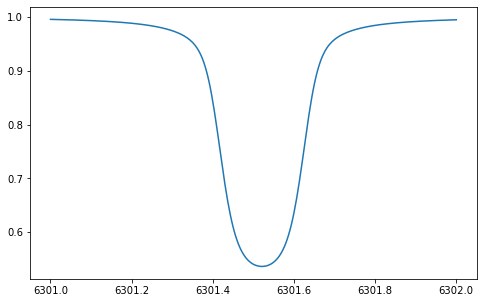

In [11]:
# Test the function as always: 

llambda = np.linspace(6301,6302,301)
plt.figure(figsize=[8,5])
plt.plot(llambda,ME(0.5,0.5,30.,1.0,2.0,0.1,6301.5,llambda))

This seems to be working, let's do the full thing:

In [17]:
def DME(a,b,eta,v,deltav,damping,bp,etap,vp,deltavp,dampingp,deltatauc,lambda0,llambda):
    
    # Now we take it easy, let's first calculate the intensity from our first atmosphere:
    I_lambda_plus  = ME(a,b,eta,v,deltav,damping,lambda0,llambda)
    
    # Now we put that into the other one, but first we need phi_lambda_prime for this
    
    c = 2.997E5
    # find the shifted line center (due to large scale velocity)
    lambdacp = lambda0*(1+vp/c)
    # doppler width in wavelength units:
    dopplerp = deltavp/c*lambda0
    
    phi_lambdap = voigt(lambdacp,dopplerp,dampingp,llambda)
    
    # This coefficient describes opacity (optical depth) scaling over the wavelengths, relative to opacity (optical depth)
    # at the referent (continuum) opacity c.
    klambdap = 1+eta*phi_lambdap
    
    delta_tau_lambda = delta_tau_c * klambdap
    
    # Don't forget the constraint:
    ap = a-bp*delta_tau_c
    
    bp /= klambdap
    
    I_lambda_plusplus = I_lambda_plus * np.exp(-delta_tau_lambda) + ap + bp - (ap+bp+bp*delta_tau_lambda)*np.exp(-delta_tau_lambda)
    
    return I_lambda_plusplus
    
    
    

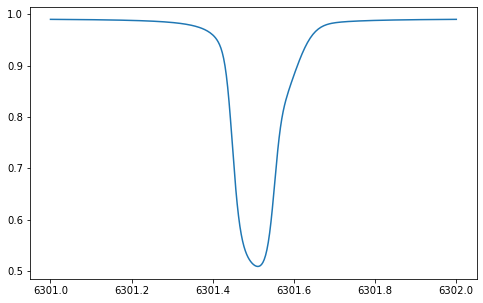

In [33]:
# Let's make an example model and test it! 

a = 0.5
b = 0.5
eta = 30.
v = 0.0
deltav = 1.0
damping = 0.1
bp = 0.4
etap = 100.0
vp = 3.0
deltavp = 2.0
dampingp = 1E-3
delta_tau_c = 1E-2

spectrum = DME(a,b,eta,v,deltav,damping,ap,bp,etap,vp,deltavp,dampingp,delta_tau_c,6301.5,llambda)
plt.figure(figsize=[8,5])
plt.plot(llambda,spectrum)
